# Лабораторная работа №4. Машинное обучение

## 1. Анализ и предобработка

### Предварительный анализ данных

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
data = pd.read_csv('./Lab4.csv')

In [334]:
data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [335]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [336]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


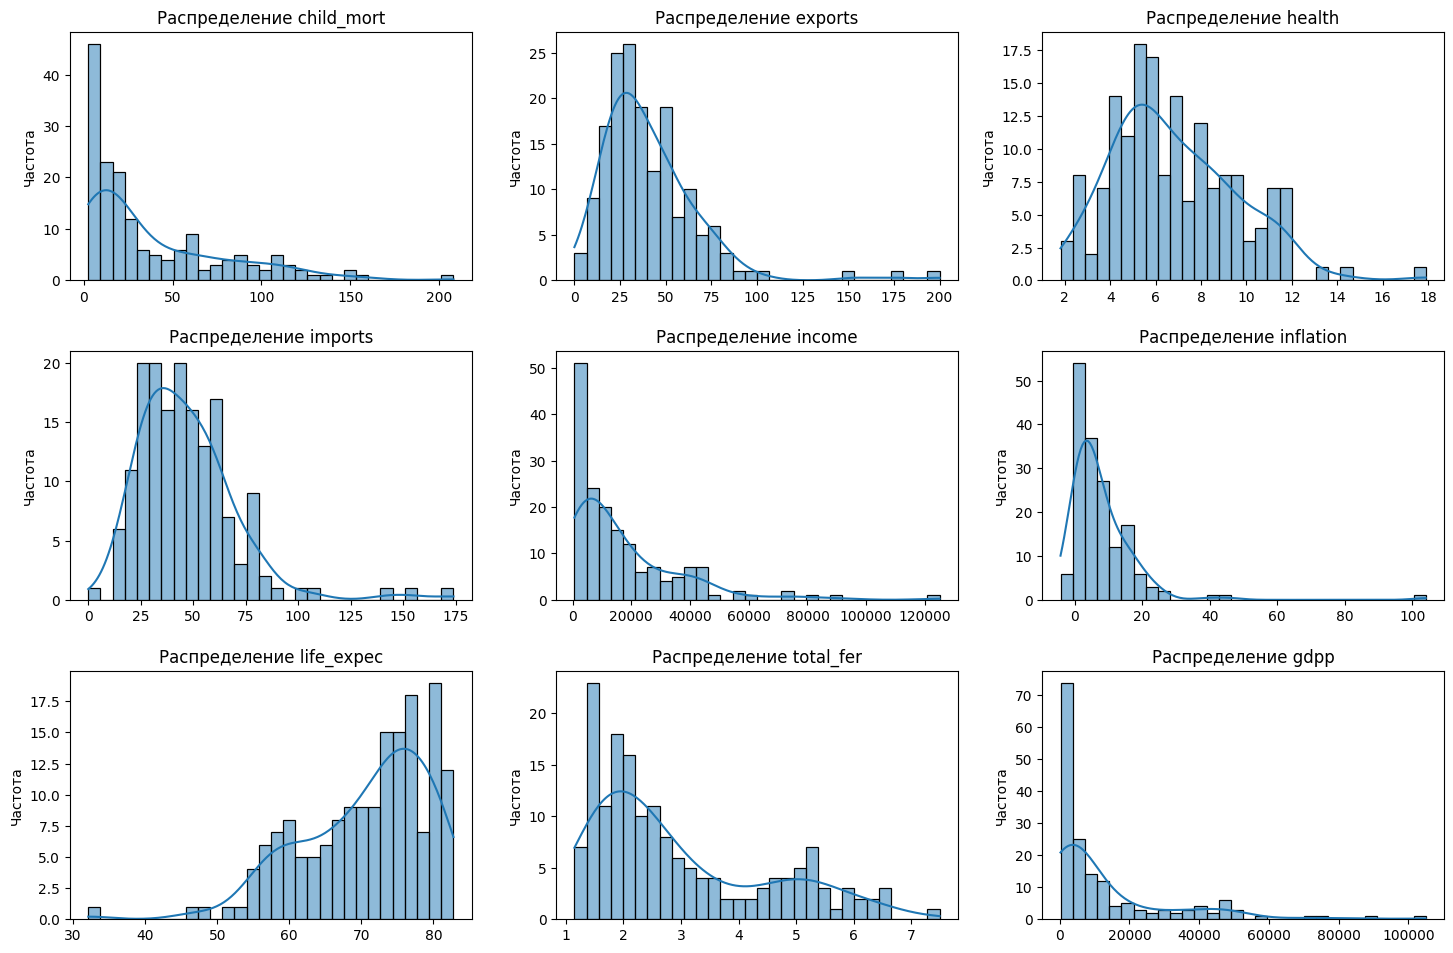

In [337]:
numerical_features = data[['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']]

num_columns = 3
num_rows = (len(numerical_features.columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
fig.tight_layout(pad=3.0)

for i, column in enumerate(numerical_features.columns):
    row, col = divmod(i, num_columns)
    sns.histplot(data[column], bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Распределение {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Частота")

for i in range(len(numerical_features.columns), num_rows * num_columns):
    axes.flatten()[i].set_visible(False)

plt.show()

По итогам предварительного анализа данных можно сделать следующие выводы:
1. 10 признаков, country имеет строковый тип данных и используется только для уникальной идентификации записей. 9 признаков будем использовать для дальнейшего анализа.
2. Пропусков в данных нет, что не может не радовать.
3. Выбросы попробуем проанализировать подробнее, однако из-за того, что данных мало и распределения выглядят довольно равномерными, нет огромных скачков, удалять выбросы может быть нецелесообразно.
5. Обязательно стоит выполнить скалирование данных перед обучением модели, так как разница диапазонов значений разных признаков довольно большая, что может негативно отразиться на работе моделей.

### Корреляция и выбросы

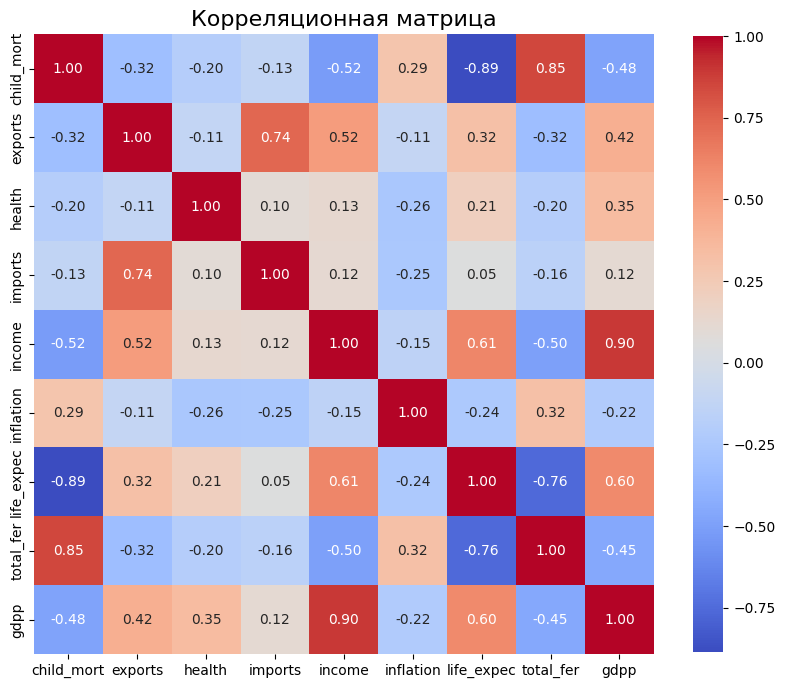

In [338]:
plt.figure(figsize=(10, 10))
sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица', fontsize=16)
plt.show()

In [339]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
columns = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']
vif = pd.DataFrame()
vif["feature"] = data[columns].columns
vif["VIF"] = [variance_inflation_factor(data[columns].values, i) for i in range(data[columns].shape[1])]

vif["VIF"] = vif["VIF"].apply(lambda x: f"{x:,.2f}")

print(vif)

      feature    VIF
0  child_mort   8.08
1     exports  16.08
2      health  12.42
3     imports  17.28
4      income  13.41
5   inflation   1.99
6  life_expec  21.92
7   total_fer  17.67
8        gdpp  10.30


Судя по корреляционной матрице и значениям VIF между многими признаками наблюдается средняя и высокая коллинеарность. Оставлять только те признаки, где VIF<5 (что соответствует низкой мультиколлинеарности) не имеет смысла, поэтому уберем все признаки, где VIF>15.

In [340]:
features = ['child_mort', 'health', 'income', 'inflation', 'total_fer', 'gdpp']

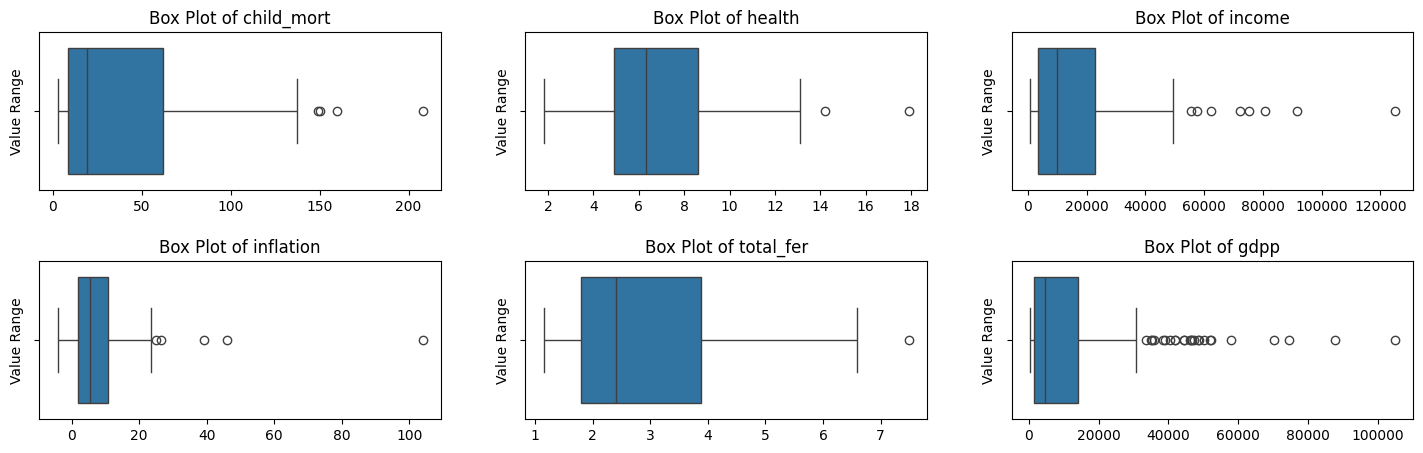

In [341]:
num_columns = 3
num_rows = (len(features) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5))
fig.tight_layout(pad=3.0)

for i, column in enumerate(features):
    row, col = divmod(i, num_columns)
    sns.boxplot(data=data[features], x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Box Plot of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Value Range")

for i in range(len(features), num_rows * num_columns):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [342]:
#columns = features

#for column in columns:
 #  Q1 = data[column].quantile(0.25)
  # Q3 = data[column].quantile(0.75)
   #IQR = Q3 - Q1
  # lower_bound = Q1 - 1.5 * IQR
  # upper_bound = Q3 + 1.5 * IQR
  # outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
   #data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]
#outliers

По итогам анализа и тестирования моделей на данных с выбросами и без них был сделан вывод, что выбросы не так уж сильно влияют на алгоритмы кластеризации и количество данных нам в данном случае важнее, поэтому было решено оставить данные в том виде, в котором они были изначально.

### Скалирование

In [343]:
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Применение методов кластеризации

### 2.1. K-means

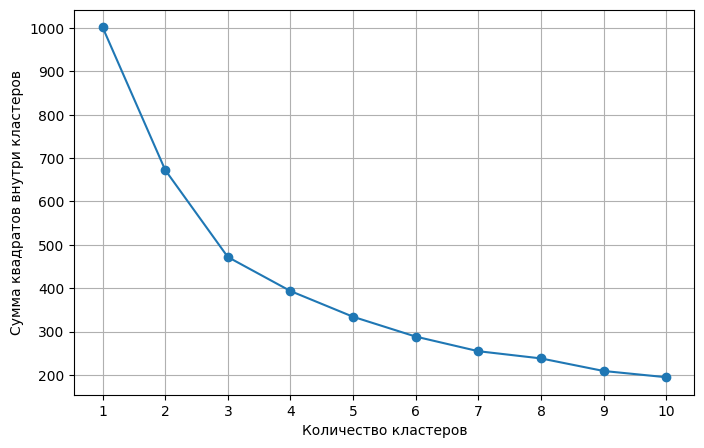

In [344]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов внутри кластеров')
plt.xticks(k_range)
plt.grid()
plt.show()


По методу локтя видим, что оптимальное число кластеров - 3

In [345]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
data['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df['cluster_kmeans'] = kmeans.labels_

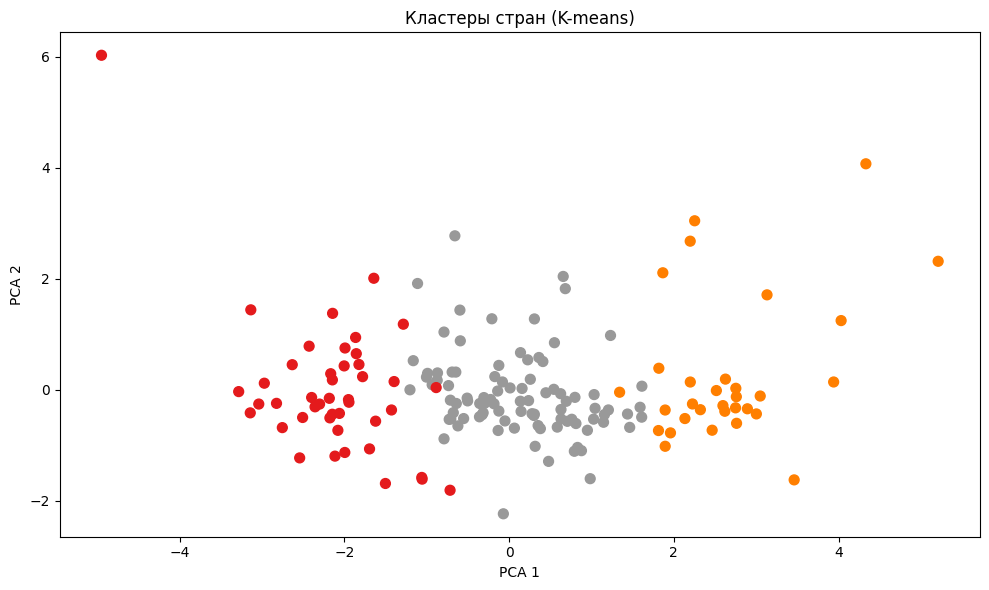

In [346]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_kmeans'], cmap='Set1', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Кластеры стран (K-means)')
plt.tight_layout()
plt.show()

Таким образом, были выделены три кластера. Странам, отнесенным в кластер 0, помощь требуется в первую очередь. Сравнительные значения признаков по кластерам и эталонные страны отражены ниже.

Средние значения признаков по кластерам:
                 child_mort    health    income  inflation  total_fer      gdpp
cluster_kmeans                                                                
0                 1.426173 -0.196271 -0.712829   0.439265   1.454603 -0.620476
1                -0.831380  0.807731  1.610220  -0.485315  -0.768925  1.814009
2                -0.401944 -0.178302 -0.201656  -0.046553  -0.436586 -0.314493


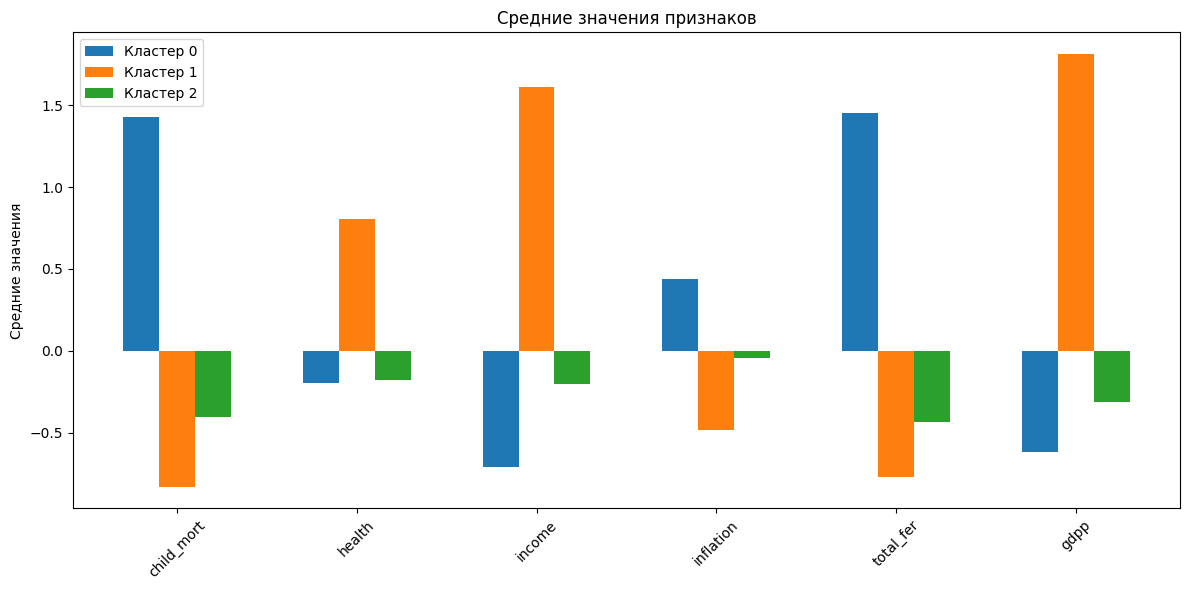

In [347]:
scaled_cluster_means = X_scaled_df.groupby('cluster_kmeans')[features].mean()
print("Средние значения признаков по кластерам:\n", scaled_cluster_means)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(features))

for i in range(scaled_cluster_means.shape[0]):
    ax.bar(x + i * bar_width, scaled_cluster_means.iloc[i], bar_width, label=f'Кластер {i}')

ax.set_xticks(x + bar_width)
ax.set_xticklabels(features, rotation=45)
ax.set_ylabel("Средние значения")
ax.set_title("Средние значения признаков")
ax.legend()
plt.tight_layout()
plt.show()

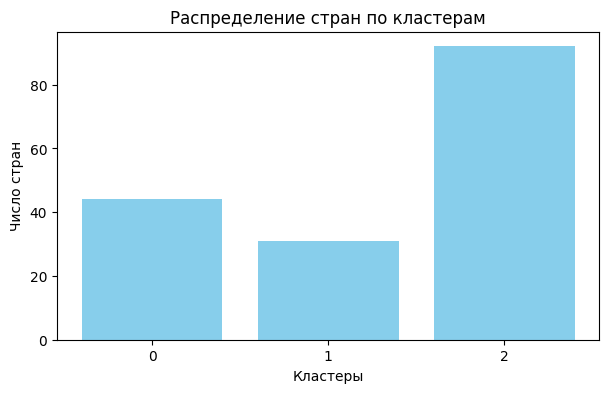

In [348]:
cluster_counts = data['cluster_kmeans'].value_counts().sort_index()
plt.figure(figsize=(7, 4))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color='skyblue')
plt.xlabel('Кластеры')
plt.ylabel('Число стран')
plt.title('Распределение стран по кластерам')
plt.show()

In [349]:
X_scaled_df_full = pd.DataFrame(X_scaled, columns=features, index=data.index)
X_scaled_df_full['cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

representatives = []
for i in range(kmeans.n_clusters):
    cluster_points = X_scaled_df_full[X_scaled_df_full['cluster'] == i].drop('cluster', axis=1)
    distances = np.linalg.norm(cluster_points.values - cluster_centers[i], axis=1)
    closest_idx = cluster_points.index[np.argmin(distances)]
    country = data.loc[closest_idx, 'country']
    representatives.append((i, country))

print("Эталонные страны по кластерам:")
for cl, country in representatives:
    row = data[data['country'] == country]
    print(f"Кластер {cl}")
    print(row.drop(columns=['cluster_kmeans']).to_string(index=False))
    print()

Эталонные страны по кластерам:
Кластер 0
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp
 Malawi        90.5     22.8    6.59     34.9    1030       12.1        53.1       5.31   459

Кластер 1
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp
Finland         3.0     38.7    8.95     37.4   39800      0.351        80.0       1.87 46200

Кластер 2
 country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp
Suriname        24.1     52.5    7.01     38.4   14200        7.2        70.3       2.52  8300



### 2.2. Иерархическая кластеризация

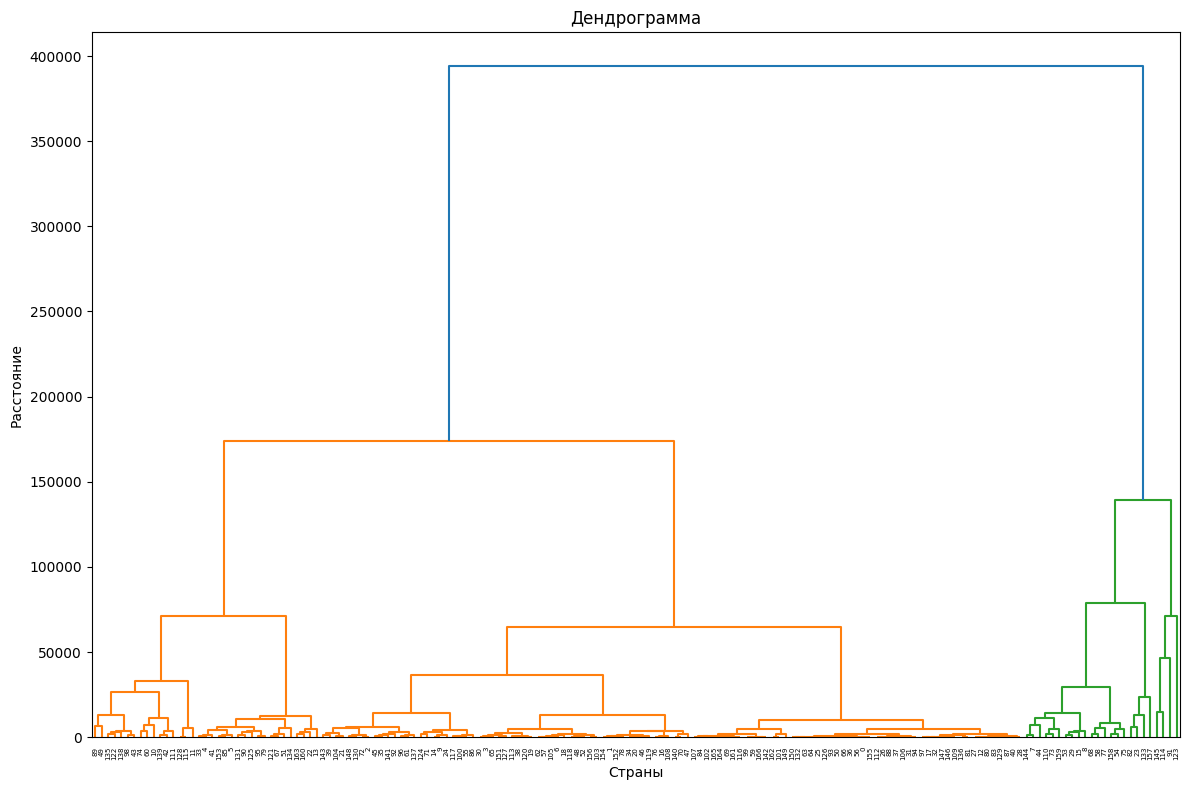

In [350]:
plt.figure(figsize=(12, 8))
linked = linkage(X, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Дендрограмма")
plt.xlabel('Страны')
plt.ylabel('Расстояние')
plt.tight_layout()
plt.show()

По дендрограмме хорошо определяются три кластера (хотя и не слишком сбалансированные, но в классификации стран это представляется нормальным)

In [351]:
num_clusters = 3
data['cluster_hierarchical'] = fcluster(linked, num_clusters, criterion='maxclust')

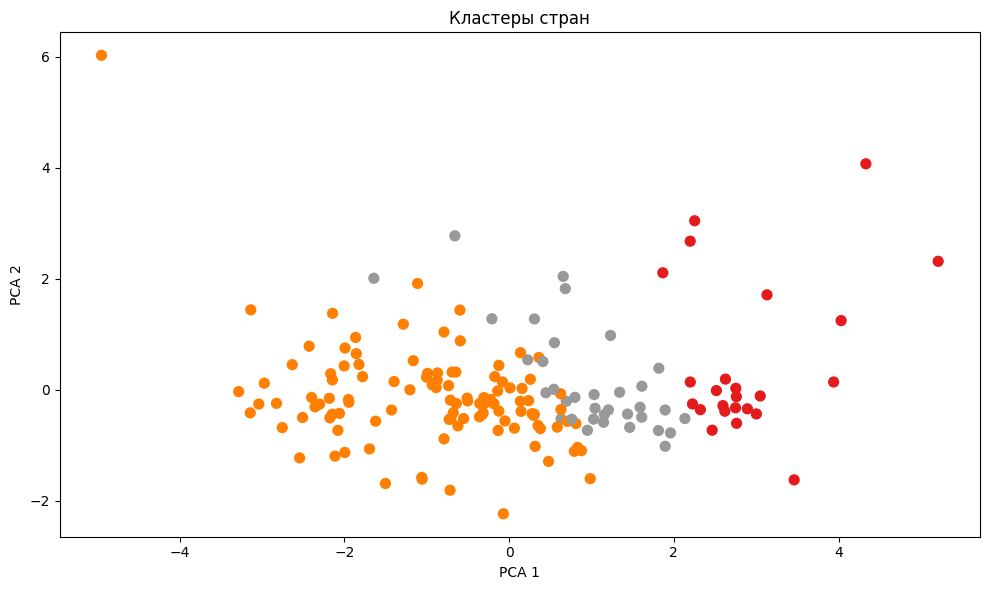

In [352]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_hierarchical'], cmap='Set1', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Кластеры стран')
plt.tight_layout()
plt.show()

В данном случае страны третьего мира относятся к кластеру 2, им нужно помогать в первую очередь. Средние показатели для каждого кластера и эталонные страны так же приведены ниже.

Средние значения признаков по иерархическим кластерам:
                       child_mort    health        income  inflation  \
cluster_hierarchical                                                  
1                       5.037500  8.996250  53250.000000   3.111708   
2                      54.058333  6.289815   6411.694444   9.158926   
3                      12.340000  6.943143  25505.714286   6.734886   

                      total_fer          gdpp  
cluster_hierarchical                           
1                      1.790833  51287.500000  
2                      3.517870   2999.759259  
3                      1.982857  17432.571429  


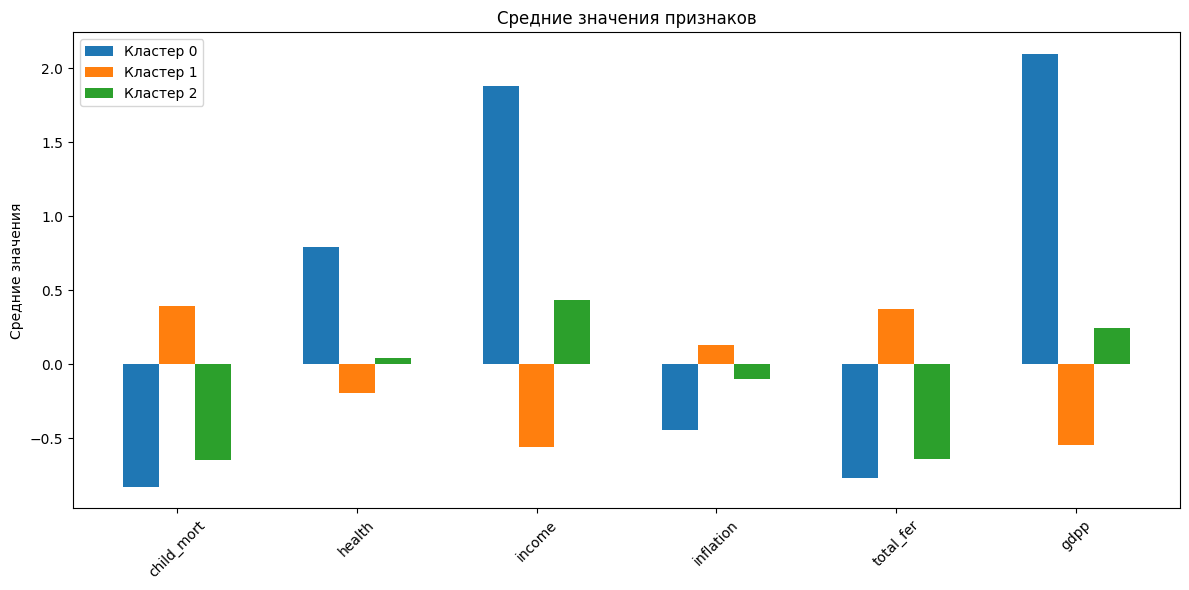

In [353]:
cluster_means_h = data.groupby('cluster_hierarchical')[features].mean()
print("Средние значения признаков по иерархическим кластерам:\n", cluster_means_h)

scaled_df = pd.DataFrame(X_scaled, columns=features)
scaled_df['cluster'] = data['cluster_hierarchical']

scaled_means = scaled_df.groupby('cluster').mean()

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(features))

for i in range(scaled_means.shape[0]):
    ax.bar(x + i * bar_width, scaled_means.iloc[i], bar_width, label=f'Кластер {i}')

ax.set_xticks(x + bar_width)
ax.set_xticklabels(features, rotation=45)
ax.set_ylabel("Средние значения")
ax.set_title("Средние значения признаков")
ax.legend()
plt.tight_layout()
plt.show()

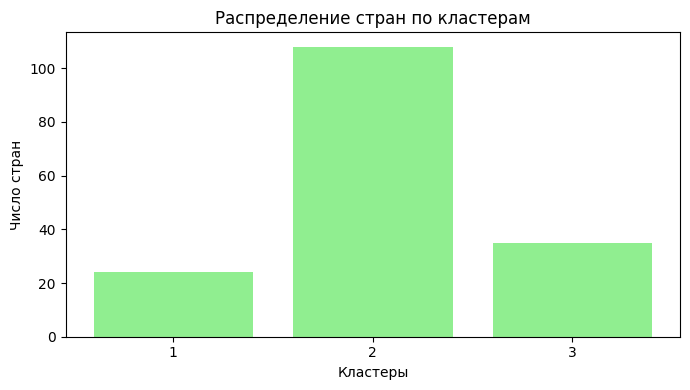

In [354]:
cluster_counts_h = data['cluster_hierarchical'].value_counts().sort_index()
plt.figure(figsize=(7, 4))
plt.bar(cluster_counts_h.index.astype(str), cluster_counts_h.values, color='lightgreen')
plt.xlabel('Кластеры')
plt.ylabel('Число стран')
plt.title('Распределение стран по кластерам')
plt.tight_layout()
plt.show()

In [355]:
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=data.index)
X_scaled_df['cluster'] = data['cluster_hierarchical']
centroids = X_scaled_df.groupby('cluster').mean().values

representatives_h = []
for i in range(1, num_clusters + 1):
    cluster_points = X_scaled_df[X_scaled_df['cluster'] == i].drop('cluster', axis=1)
    distances = np.linalg.norm(cluster_points.values - centroids[i - 1], axis=1)
    closest_idx = cluster_points.index[np.argmin(distances)]
    country = data.loc[closest_idx, 'country']
    representatives_h.append((i, country))

print("Эталонные страны по кластерам:")
for cl, country in representatives_h:
    row = data[data['country'] == country]
    print(f"Кластер {cl}")
    print(row.to_string(index=False))
    print()


Эталонные страны по кластерам:
Кластер 1
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical
 Sweden         3.0     46.2    9.63     40.7   42900      0.991        81.5       1.98 52100               1                     1

Кластер 2
   country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical
Tajikistan        52.4     14.9    5.98     58.6    2110       12.5        69.6       3.51   738               2                     2

Кластер 3
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical
 Turkey        19.1     20.4    6.74     25.5   18000       7.01        78.2       2.15 10700               2                     3



### 2.3. DBSCAN

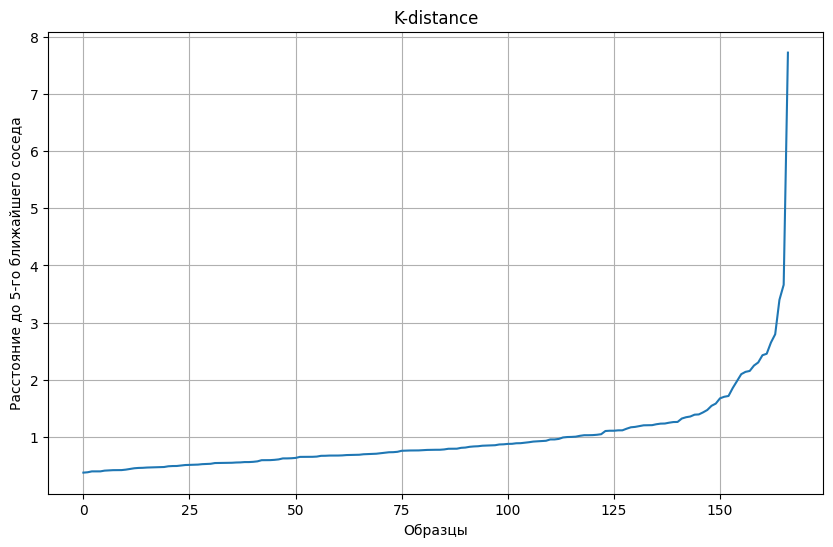

In [356]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance')
plt.xlabel('Образцы')
plt.ylabel('Расстояние до 5-го ближайшего соседа')
plt.grid()
plt.show()

Методом анализа графика выше и некоторого перебора значений было установлено оптимальное расстрояние до ближайшего соседа и минимальное количество элементов для образования кластера.

In [357]:
eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

unique_clusters = sorted([c for c in np.unique(clusters) if c != -1])
cluster_mapping = {old: new for new, old in enumerate(unique_clusters)}
cluster_mapping[-1] = -1
renumbered_clusters = [cluster_mapping[c] for c in clusters]
data['cluster_dbscan'] = renumbered_clusters

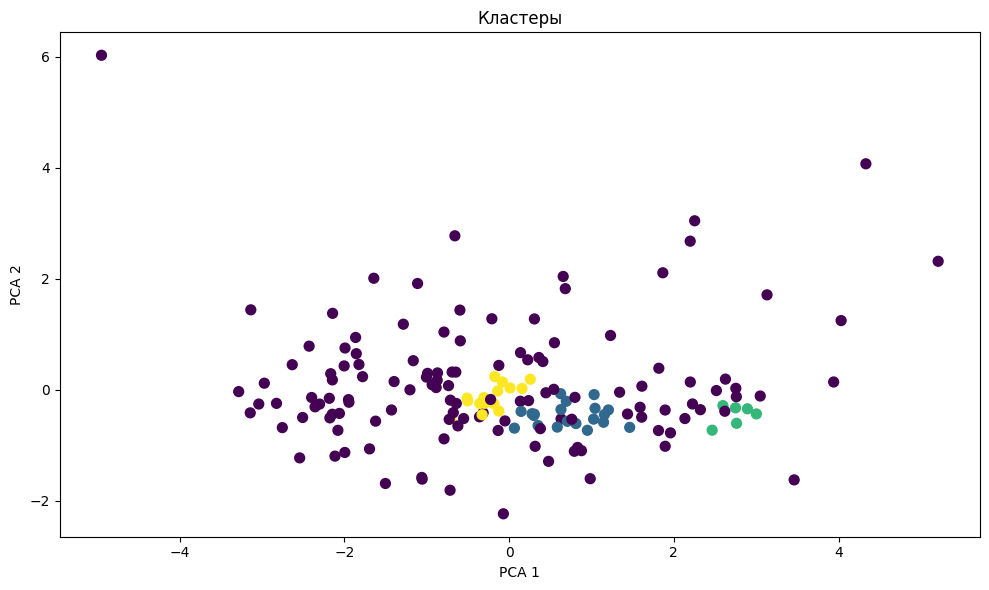

In [358]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_dbscan'], cmap='viridis', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Кластеры')
plt.tight_layout()
plt.show()

Таким образом, выделены три кластера (не самая лучшая кластеризация, но лучший вариант, которого удалось добиться). Помощь требуется в первую очередь странам из кластера 2, подробнее срезние значения признаков по каждому кластеру и эталонные страны приведены ниже.

Средние значения признаков по кластерам DBSCAN:
    cluster_dbscan  child_mort     health        income  inflation  total_fer  \
0               0       11.25   6.855500  16141.500000   1.829650   1.724000   
1               1        4.55  11.400000  41300.000000   1.379833   1.690000   
2               2       26.26   5.027333   7885.333333   4.798733   2.365333   

           gdpp  
0   9515.500000  
1  45233.333333  
2   3840.400000  


<ipython-input-359-88ed13c7fd2a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scaled_df['cluster'] = filtered_scaled_df['cluster'].astype(int)


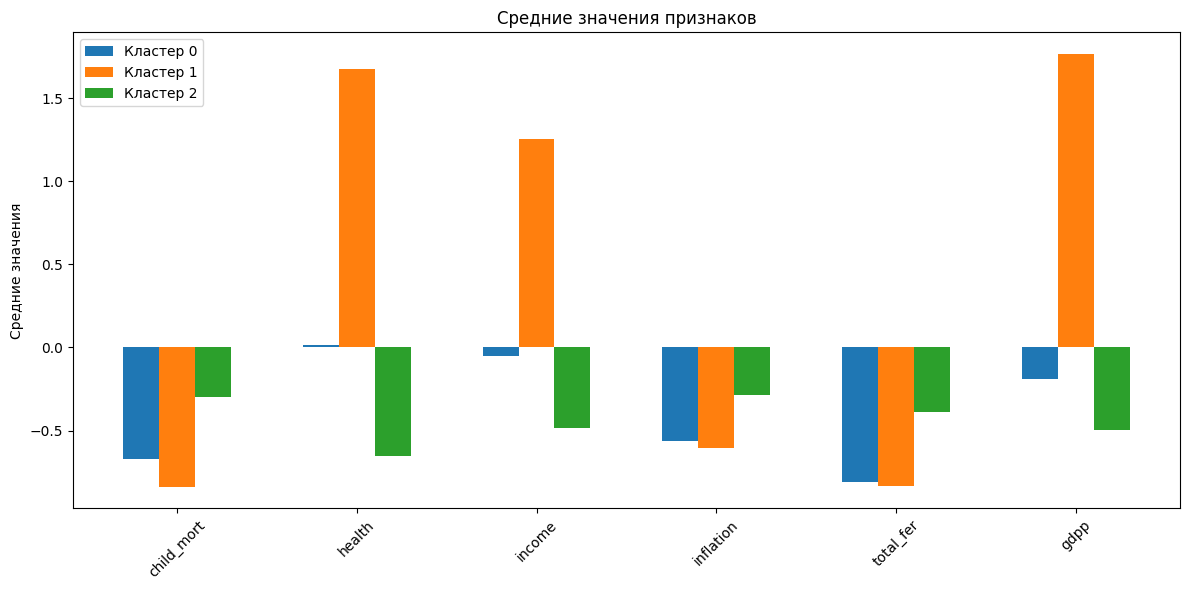

In [359]:
features_with_cluster = features + ['cluster_dbscan']
dbscan_description = data[data['cluster_dbscan'] != -1][features_with_cluster].groupby('cluster_dbscan').mean().reset_index()
print('Средние значения признаков по кластерам DBSCAN:\n', dbscan_description)

scaled_df = pd.DataFrame(X_scaled, columns=features, index=data.index)
scaled_df['cluster'] = data['cluster_dbscan']

filtered_scaled_df = scaled_df[scaled_df['cluster'] != -1]
filtered_scaled_df['cluster'] = filtered_scaled_df['cluster'].astype(int)
filtered_scaled_means = filtered_scaled_df.groupby('cluster').mean().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(features))

for i, cluster in enumerate(filtered_scaled_means.index):
    ax.bar(x + i * bar_width, filtered_scaled_means.loc[cluster], bar_width, label=f'Кластер {cluster}')

ax.set_xticks(x + bar_width * (filtered_scaled_means.shape[0] - 1) / 2)
ax.set_xticklabels(features, rotation=45)
ax.set_ylabel("Средние значения")
ax.set_title("Средние значения признаков")
ax.legend()
plt.tight_layout()
plt.show()

   cluster_dbscan  country_count
0               0             20
1               1              6
2               2             15


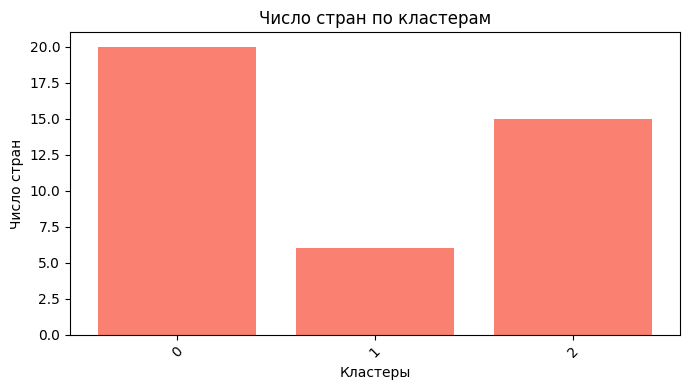

In [360]:
dbscan_count = data[data['cluster_dbscan'] != -1]['cluster_dbscan'].value_counts().sort_index().reset_index()
dbscan_count.columns = ['cluster_dbscan', 'country_count']
print(dbscan_count)

plt.figure(figsize=(7, 4))
plt.bar(dbscan_count['cluster_dbscan'].astype(str), dbscan_count['country_count'], color='salmon')
plt.xlabel('Кластеры')
plt.ylabel('Число стран')
plt.title('Число стран по кластерам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [361]:
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=data.index)
X_scaled_df['cluster'] = data['cluster_dbscan']
centroids = X_scaled_df[X_scaled_df['cluster'] != -1].groupby('cluster').mean().values

representatives_dbscan = []
for i in sorted(X_scaled_df['cluster'].unique()):
    if i == -1:
        continue
    cluster_points = X_scaled_df[X_scaled_df['cluster'] == i].drop('cluster', axis=1)
    distances = np.linalg.norm(cluster_points.values - centroids[i], axis=1)
    closest_idx = cluster_points.index[np.argmin(distances)]
    country = data.loc[closest_idx, 'country']
    representatives_dbscan.append((i, country))

print("Эталонные страны по кластерам:")
for cl, country in representatives_dbscan:
    row = data[data['country'] == country]
    print(f"Кластер {cl}")
    print(row.to_string(index=False))
    print()

Эталонные страны по кластерам:
Кластер 0
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical  cluster_dbscan
Lebanon        10.3     35.8    7.03     60.2   16300      0.238        79.8       1.61  8860               2                     2               0

Кластер 1
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical  cluster_dbscan
 Canada         5.6     29.1    11.3     31.0   40700       2.87        81.3       1.63 47400               1                     1               1

Кластер 2
country  child_mort  exports  health  imports  income  inflation  life_expec  total_fer  gdpp  cluster_kmeans  cluster_hierarchical  cluster_dbscan
   Fiji        24.1     57.8    4.86     63.9    7350       4.23        65.3       2.67  3650               2                     2               2

